In [1]:
import cv2
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
from cv2 import aruco
import matplotlib.pyplot as plt
import os
import polars as pl
import toml
import sys
from tqdm import tqdm
sys.path.append(os.path.join(os.getcwd(), ".."))
from support.pd_support import *

from datetime import datetime
from support.pd_support import *
from support.ar_calculations import *
from ultralytics import YOLO
from scipy.spatial.transform import Rotation as R

In [2]:
_base_pth = os.path.join(os.getcwd(), "recordings")
_folder_name = "webcam_random_t0"
_video_pth = os.path.join(_base_pth, _folder_name, "webcam_color.msgpack")
_timestamp_pth = os.path.join(_base_pth, _folder_name, "webcam_timestamp.msgpack")

model = YOLO(r"E:\CMC\pyprojects\DeepVision\models_save\mip_ar_200e_noise.pt")

In [3]:
_webcam_calib_pth = r"E:\CMC\pyprojects\DeepVision\recorded_data\paper\calibration_00\webcam_calibration.msgpack"
with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    camera_mat = _temp[0]
    dist_coef = _temp[1]

In [4]:
with open(_timestamp_pth, "rb") as f:
    timestamps = list(mp.Unpacker(f, object_hook=mpn.decode))
    
with open(_video_pth, "rb") as f:
    video_data = list(mp.Unpacker(f, object_hook=mpn.decode))
    
_time = np.array(timestamps)[:, 0]
_time = [datetime.fromtimestamp(float(_t)) for _t in _time]

_sync_file = os.path.join(_base_pth, _folder_name, "sync01.csv")
_sync = pd.read_csv(_sync_file)
_sync = pl.from_pandas(_sync)

start_idx = _sync["sync"].to_list().index(1)
end_idx = start_idx + _sync[start_idx:]["sync"].to_list().index(0)
_sync = _sync[start_idx:end_idx]

sync_start_time = datetime.fromtimestamp(_sync["rust_time"][0])
sync_end_time = datetime.fromtimestamp(_sync["rust_time"][-1])

In [5]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_MIP_36H12)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ARUCO_DICT,
)


def estimatePoseSingleMarkers(corners, marker_size, mtx, distortion):
    marker_points = np.array(
        [
            [-marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, -marker_size / 2, 0],
            [-marker_size / 2, -marker_size / 2, 0],
        ],
        dtype=np.float32,
    )
    trash = []
    rvecs = []
    tvecs = []
    for c in corners:
        nada, R, t = cv2.solvePnP(
            marker_points, c, mtx, distortion, True, flags=cv2.SOLVEPNP_ITERATIVE
        )

        if not (R is None or t is None):
            R = np.array(R).reshape(1, 3).tolist()
            t = np.array(t).reshape(1, 3).tolist()

        rvecs.append(R)
        tvecs.append(t)
    return rvecs, tvecs

In [6]:
data = {"frame_id": [], "marker_ids": [], "corners": [], "tvec": [], "rvec": []}
counter = 0

for _frame in tqdm(video_data):
    _frame = cv2.cvtColor(_frame, cv2.COLOR_RGBA2RGB)
    yolo_results = model.predict(_frame, verbose=False, imgsz=640, conf=0.8)[0]
    modelcorners = []
    for _keys in yolo_results.keypoints.data:
        modelcorners.append(_keys[0:4].cpu().numpy())
    modelcorners = np.array(modelcorners)
    corners = modelcorners
    if (
        len(yolo_results.boxes.cls.cpu().numpy()) != 0
    ):  # if there are any detections else None
        _idx = yolo_results.boxes.cls.cpu().numpy()
        ids = []
        for i in _idx:
            match i:
                case 0:
                    ids.append([12])
                case 1:
                    ids.append([88])
                case 2:
                    ids.append([89])
        ids = np.array(ids, dtype=np.int32)
    else:
        ids = None


    if ids is None:
        data["frame_id"].append(counter)
        data["marker_ids"].append(None)
        data["corners"].append(None)
        data["tvec"].append(None)
        data["rvec"].append(None)

    if ids is not None:
        rvec, tvec = estimatePoseSingleMarkers(
            corners=corners,
            marker_size=0.05,
            mtx=camera_mat,
            distortion=dist_coef,
        )
        data["frame_id"].append(counter)
        data["marker_ids"].append(ids)
        data["corners"].append(corners)
        data["tvec"].append(tvec)
        data["rvec"].append(rvec)
    counter += 1

  0%|          | 0/570 [00:00<?, ?it/s]

c:\Users\Pintu\miniconda3\envs\py12\Lib\site-packages\torch\cuda\__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
  3%|▎         | 18/570 [00:45<05:59,  1.54it/s] 

In [ ]:
default_ids = [12, 14, 20, 88, 89]
coordinate = {
    str(id): {"x": [], "y": [], "z": [], "rx": [], "ry": [], "rz": []}
    for id in default_ids
}

for i, frame_id in enumerate(data["frame_id"]):
    if data["marker_ids"][i] is not None:
        existing_ids = set(data["marker_ids"][i].reshape(-1))
        missing_ids = set(default_ids) - existing_ids

        for _m, tvec, rvec in zip(
            data["marker_ids"][i], data["tvec"][i], data["rvec"][i]
        ):
            if _m in default_ids:
                coord = coordinate[str(_m[0])]
                coord["x"].append(tvec[0][0])
                coord["y"].append(tvec[0][1])
                coord["z"].append(tvec[0][2])
                coord["rx"].append(rvec[0][0])
                coord["ry"].append(rvec[0][1])
                coord["rz"].append(rvec[0][2])

        for _m in missing_ids:
            coord = coordinate[str(_m)]
            coord["x"].append(np.nan)
            coord["y"].append(np.nan)
            coord["z"].append(np.nan)
            coord["rx"].append(np.nan)
            coord["ry"].append(np.nan)
            coord["rz"].append(np.nan)
    else:
        for _m in default_ids:
            coord = coordinate[str(_m)]
            coord["x"].append(np.nan)
            coord["y"].append(np.nan)
            coord["z"].append(np.nan)
            coord["rx"].append(np.nan)
            coord["ry"].append(np.nan)
            coord["rz"].append(np.nan)

In [ ]:
ar_df = pl.from_dicts(coordinate["88"])
rvec = ar_df[["rx", "ry", "rz"]][0].to_numpy()
ar_rotmat = cv2.Rodrigues(rvec)[0]

tar = ar_rotmat.T @ (
    ar_df[["x", "y", "z"]].to_numpy().T - ar_df[["x", "y", "z"]][0].to_numpy().T
)
_ar_df = pl.from_dicts({"time": _time, "x": tar[0], "y": tar[1], "z": tar[2]})

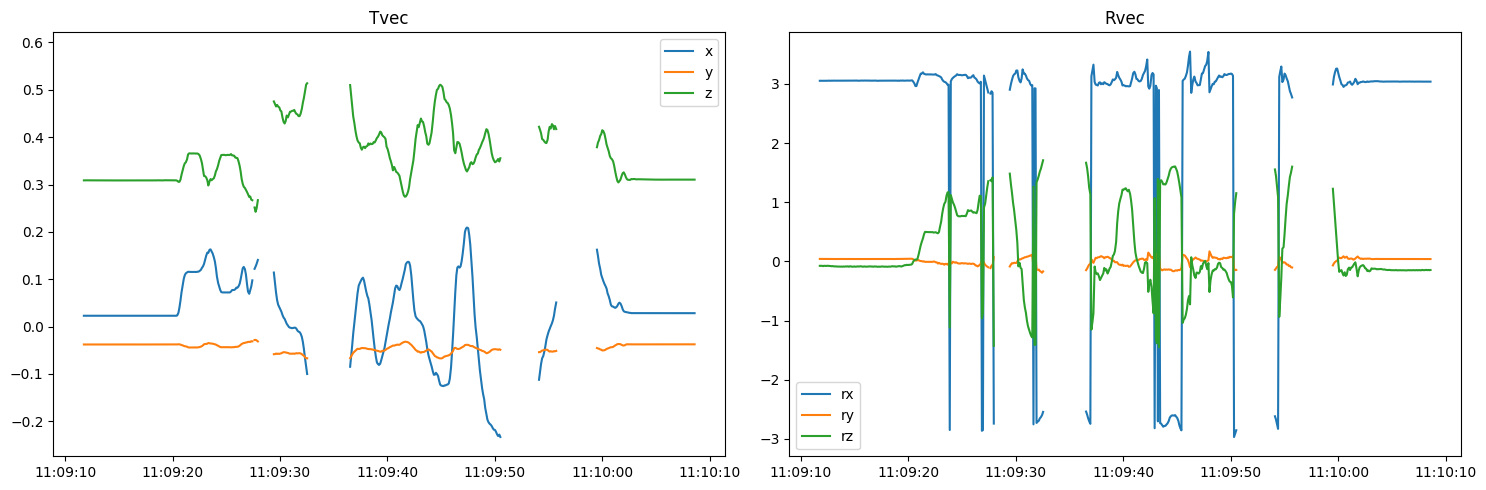

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(_ar_df["time"], coordinate['88']["x"], label="x")
ax1.plot(_ar_df["time"], coordinate['88']["y"], label="y")
ax1.plot(_ar_df["time"], coordinate['88']["z"], label="z")
# ax1.plot(_ar_df["time"], coordinate['89']["x"], label="x")
# ax1.plot(_ar_df["time"], coordinate['89']["y"], label="y")
# ax1.plot(_ar_df["time"], coordinate['89']["z"], label="z")
ax1.set_title("Tvec")

ax1.set_title("Tvec")
ax1.legend()
ax2.plot(_ar_df["time"], coordinate["88"]["rx"], label="rx")
ax2.plot(_ar_df["time"], coordinate["88"]["ry"], label="ry")
ax2.plot(_ar_df["time"], coordinate["88"]["rz"], label="rz")
ax2.set_title("Rvec")
ax2.legend()
plt.tight_layout()
plt.show()


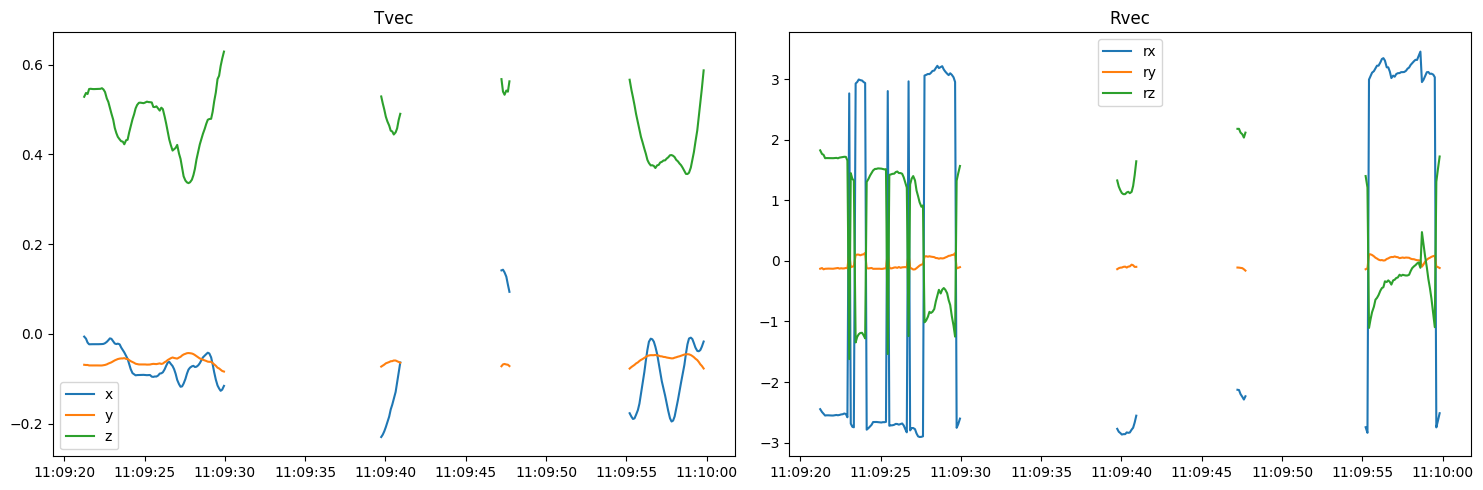

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(_ar_df["time"], coordinate['89']["x"], label="x")
ax1.plot(_ar_df["time"], coordinate['89']["y"], label="y")
ax1.plot(_ar_df["time"], coordinate['89']["z"], label="z")
ax1.set_title("Tvec")
ax1.legend()
ax2.plot(_ar_df["time"], coordinate["89"]["rx"], label="rx")
ax2.plot(_ar_df["time"], coordinate["89"]["ry"], label="ry")
ax2.plot(_ar_df["time"], coordinate["89"]["rz"], label="rz")
ax2.set_title("Rvec")
ax2.legend()
plt.tight_layout()
plt.show()


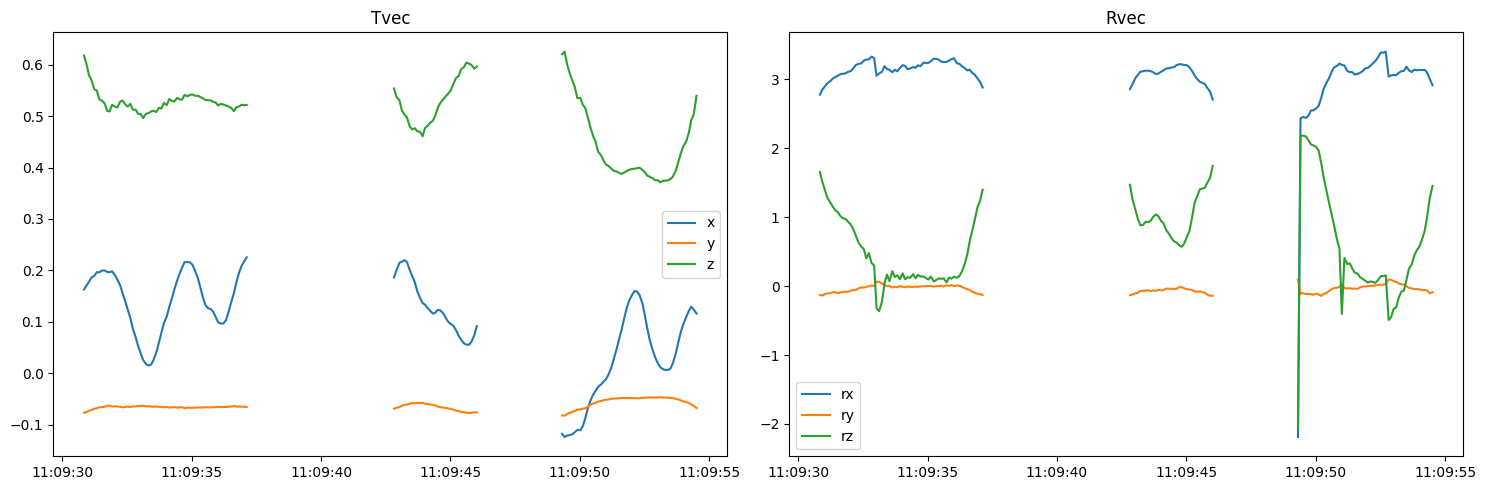

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(_ar_df["time"], coordinate['12']["x"], label="x")
ax1.plot(_ar_df["time"], coordinate['12']["y"], label="y")
ax1.plot(_ar_df["time"], coordinate['12']["z"], label="z")
ax1.set_title("Tvec")
ax1.legend()
ax2.plot(_ar_df["time"], coordinate["12"]["rx"], label="rx")
ax2.plot(_ar_df["time"], coordinate["12"]["ry"], label="ry")
ax2.plot(_ar_df["time"], coordinate["12"]["rz"], label="rz")
ax2.set_title("Rvec")
ax2.legend()
plt.tight_layout()
plt.show()


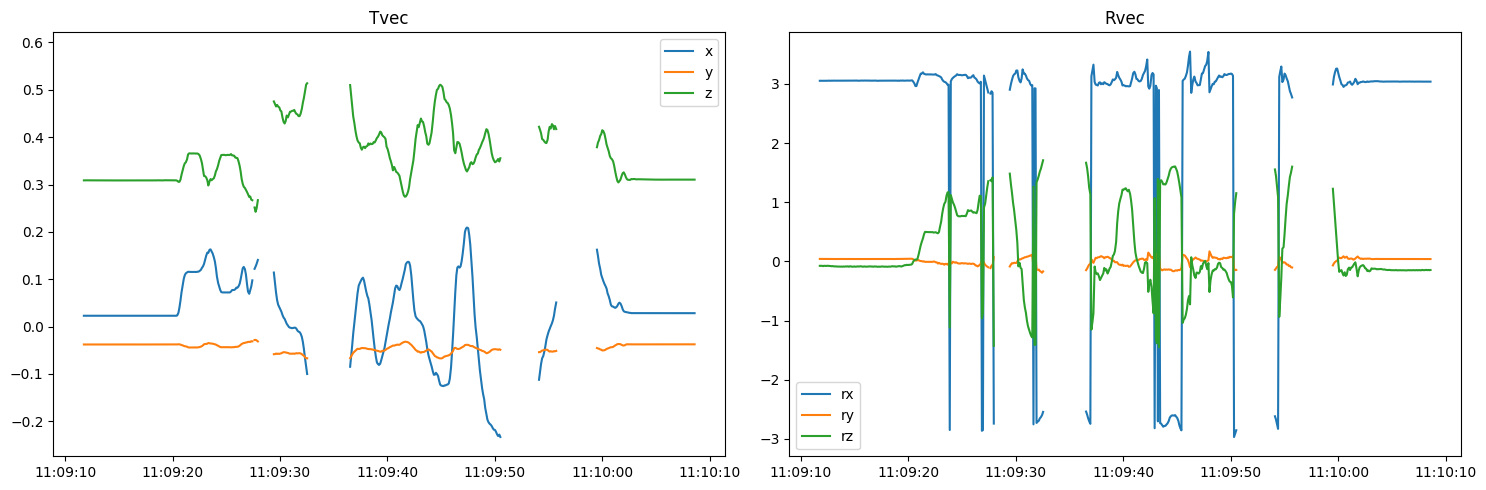

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(_ar_df["time"], coordinate['88']["x"], label="x")
ax1.plot(_ar_df["time"], coordinate['88']["y"], label="y")
ax1.plot(_ar_df["time"], coordinate['88']["z"], label="z")
ax1.set_title("Tvec")
ax1.legend()
ax2.plot(_ar_df["time"], coordinate["88"]["rx"], label="rx")
ax2.plot(_ar_df["time"], coordinate["88"]["ry"], label="ry")
ax2.plot(_ar_df["time"], coordinate["88"]["rz"], label="rz")
ax2.set_title("Rvec")
ax2.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Define offsets

offsets = {
    12: np.array([-0.05, 0.03, -0.055]),
    14: np.array([0.00, 0.1025, -0.069]),
    20: np.array([0.00, 0.01, -0.069]),
    88: np.array([0.00, 0.03, -0.16]),
    89: np.array([0.05, 0.03, -0.055]),
}

# offsets = {
#     12: np.array([-0.05, 0.03, -0.055]),
#     14: np.array([0.00, 0.1025, -0.069]),
#     20: np.array([0.00, 0.01, -0.069]),
#     88: np.array([0.00, 0.03, -0.11]),
#     89: np.array([0.05, 0.03, -0.055]),
# }

offsets = {
    12: np.array([-0.09, 0.0, -0.069]),
    14: np.array([0.00, 0.1025, -0.069]),
    20: np.array([0.00, 0.01, -0.069]),
    88: np.array([0.00, 0.0, -0.1075]),
    89: np.array([0.1, 0.0, -0.055]),
}

# Function to compute transformed coordinates
def compute_transformed_coordinates(coordinate, id_offset):
    rotation_matrix = R.from_rotvec(
        np.array([coordinate["rx"], coordinate["ry"], coordinate["rz"]]).T
    ).as_matrix()
    translation_vector = np.array([coordinate["x"], coordinate["y"], coordinate["z"]])
    transformed = np.array(
        [
            (_r @ id_offset.reshape(3, 1) + _t.reshape(3, 1)).T[0]
            for _r, _t in zip(rotation_matrix, translation_vector.T)
        ]
    )
    return rotation_matrix, translation_vector, transformed


# Compute transformations
results = {}
for key in offsets.keys():
    results[key] = compute_transformed_coordinates(coordinate[str(key)], offsets[key])

# Transform to global coordinates
_r_88_inv = results[88][0][0].T
_tvec_88_0 = results[88][2][0]

world_coordinates = {}
for key in offsets.keys():
    world_coordinates[key] = _r_88_inv @ (results[key][2] - _tvec_88_0).T

_gt_12, _gt_14, _gt_20, _gt_88, _gt_89 = [
    world_coordinates[key] for key in [12, 14, 20, 88, 89]
]
_mean_val = np.nanmean([_gt_12, _gt_14, _gt_20, _gt_88, _gt_89], axis=0)
# _mean_val = np.nanmean([_gt_88], axis=0)

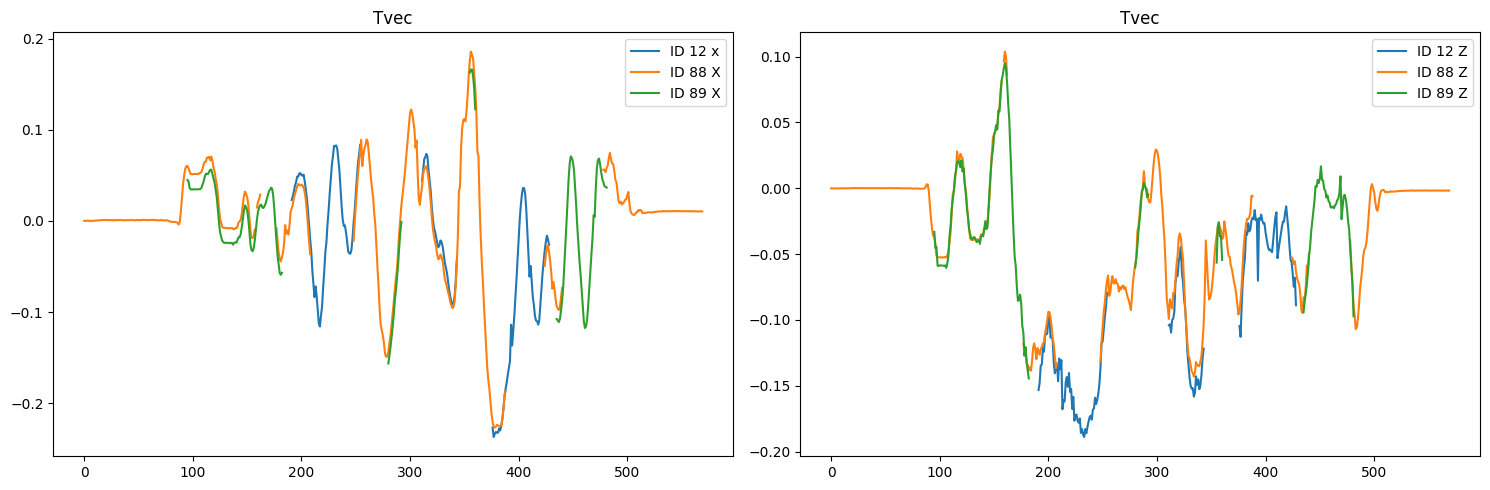

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(_gt_12[0], label="ID 12 x")
ax1.plot(_gt_88[0], label="ID 88 X")
ax1.plot(_gt_89[0], label="ID 89 X")
ax1.set_title("Tvec")
ax1.legend()
ax2.plot(_gt_12[2], label="ID 12 Z")
ax2.plot(_gt_88[2], label="ID 88 Z")
ax2.plot(_gt_89[2], label="ID 89 Z")
ax2.set_title("Tvec")
ax2.legend()
plt.tight_layout()
plt.show()


In [ ]:
_mocap_pth = os.path.join(_base_pth, 'mocap', _folder_name + '.csv')
mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
mocap_df = add_datetime_col(mocap_df, st_time, "seconds")
mocap_df = pl.from_pandas(mocap_df)

# _mean_val = _mean_val.T[start_idx:end_idx]

_mocap_quat = R.from_quat(
    mocap_df[["rb_ang_x", "rb_ang_y", "rb_ang_z", "rb_ang_w"]][0].to_numpy()
)
_mocap_mat = _mocap_quat.as_matrix()[0]
_time_offset = sync_start_time - mocap_df["time"][0]
mocap_df = mocap_df.with_columns([(pl.col("time") + _time_offset).alias("time")])
_mean_val = _mean_val.T


e:\CMC\pyprojects\DeepVision\wearable\..\support\pd_support.py:326: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  _rb_df = _rb_df.apply(pd.to_numeric, errors="ignore")


In [ ]:
_m = get_rb_marker_name(6)
_m_org = mocap_df[[_m["x"], _m["y"], _m["z"]]][0].to_numpy().T
_m_tvec = mocap_df[[_m["x"], _m["y"], _m["z"]]].to_numpy().T
_m_transformed = _mocap_mat.T @ (_m_tvec - _m_org)

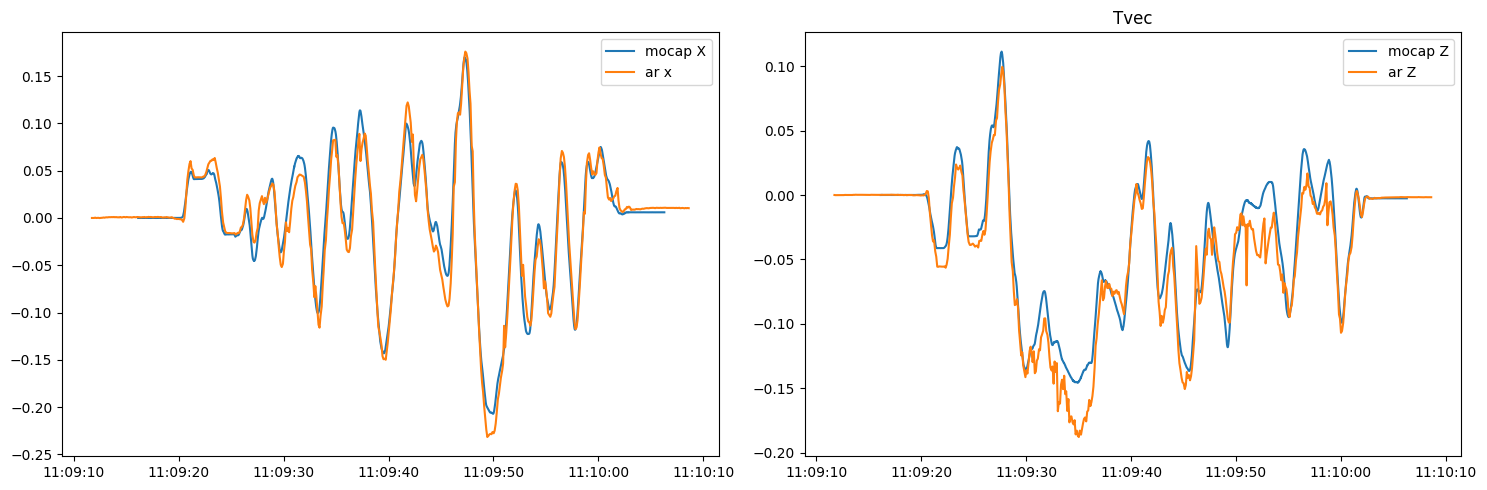

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(mocap_df["time"], _m_transformed[0], label="mocap X")
ax1.plot(_time, _mean_val[:,0], label="ar x")
ax1.legend()
ax2.plot(mocap_df["time"], _m_transformed[2], label="mocap Z")
ax2.plot(_time, _mean_val[:,2], label="ar Z")
ax2.set_title("Tvec")
ax2.legend()
plt.tight_layout()
plt.show()
